In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random as ran
from tensorflow.contrib.layers import flatten


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Introdução ao Tensorflow

* Biblioteca de software de código aberto para computação numérica que usa gráficos de fluxo de dados
* Nós no gráfico representam operações matemáticas,
* Arestas representam as matrizes ou tensores de dados multidimensionais que se comunicam com os nós

![alt text](imgs/tf_graph.png "Title")

#### O que são nós? 

Operadores, variáveis, constantes

##### O que são arestas? 

Os tensors

![alt text](imgs/tf_add.png "Title")

#### Como realizar uma operação?

O tensorflow possui um objeto, denominado Session, responsável por executar as operações e tensors criados 

#### TensorFlow = tensor + flow = data + flow 

![alt text](imgs/200w_d.gif "Title")


In [2]:
a = tf.add(3, 5)
with tf.Session() as sess:
	print(sess.run(a))

8


### MNIST no Tensorflow

1. Criar variáveis de entrada (X) e saída (y_t) através de placeholders
2. Inicializar pesos e bias

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", reshape=False, one_hot=True)
train_X, train_y           = mnist.train.images, mnist.train.labels
valid_X, valid_y = mnist.validation.images, mnist.validation.labels
test_X, test_y             = mnist.test.images, mnist.test.labels

#train_X = train_X.reshape(-1, 28, 28, 1)
#test_X = test_X.reshape(-1,28,28,1)
    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Pad images with 0s
train_X      = np.pad(train_X, ((0,0),(2,2),(2,2),(0,0)), 'constant')
valid_X = np.pad(valid_X, ((0,0),(2,2),(2,2),(0,0)), 'constant')
test_X       = np.pad(test_X, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [5]:
training_iters = 10
learning_rate = 0.001 
batch_size = 128

### Definir as entradas e saídas da rede

Para o tensorflow, as entradas e saídas da rede são definidas a partir de Placeholders, que são estruturas capazes de construir o grafo, assim como suas operações, sem associar aos dados inicialmente de forma direta. Para implementar um placeholder, definimos o tipo do mesmo (e.g. float) e suas dimensões. Para o MNIST, como a entrada tem formato 28x28x1 (widthxheightxchannel), o placeholder deverá possuir a mesma dimensão. Da mesma forma, o placeholder y deverá conter o número de classes do problema que, para o MNIST, possui valor igual a 10. Além disso, ambos placeholders possuem uma dimensão None, significando dizer que a quantidade de instâncias do placeholder será definida posteriormente. 

In [6]:
# MNIST data input (img shape: 28*28)
n_input = 32

# MNIST total classes (0-9 digits)
n_classes = 10

#both placeholders are of type float
x = tf.placeholder("float", [None, 32,32,1])
y = tf.placeholder("float", [None, n_classes])

### Criando funções de convolução e pooling auxiliares

O tensorflow possui funções nativas para realizar convolução, entretanto, a criação da camada convolucional requer três passos principais:
1. Definir parâmetros dos filtros, strides e padding, a partir da função conv2d
2. Adicionar bias
3. Limitar a saída de 2. através da função de ativação

Assim, para simplificar, define-se uma função conv2d com as três funções do tensorflow responsáveis pelos passos definidos anteriormente. Da mesma forma, define-se a função maxpool2d.

In [7]:
def conv2d(x, W, b, strides=1):
    """
    Função para implementar a camada convolucional.
    Parâmetros: x - camada prévia da rede 
                W - dimensão e quantidade de filtros utilizados
                b - bias de cada camada
    
    """
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

### Definindo os pesos e bias

Além de inicializar os placeholders, no tensorflow também é necessário definir as variáveis, que para redes neurais podem ser pesos e bias. Em uma rede neural, cada camada possui seus respectivos pesos e bias. Da mesma forma, em uma rede convolucional, cada camada possui seus filtros que devem ser definidos através das variáveis.

Assim, para a primeira camada, a variável wc1 define os pesos da mesma no formato (width, height, channel, quantidade de filtros). Para a LeNet, utilizaremos dimensão 5x5 de filtros, um único canal (imagem em tons de cinza) e 6 filtros convolucionais. Da mesma forma, para a segunda camada, inicializamos os pesos com dimensão 5x5, entretanto, o número de canais será igual a 6, uma vez que a camada anterior produz 6 mapas de característica. 

Da mesma forma, cada camada possui bias, sendo um para cada filtro. Dessa forma, a variável bias terá como dimensão a quantidade de filtros desta camada (e.g. 6 para a primeira camada e 16 para a segunda). 

Por fim, para cada camada, o tensorflow possui inicializadores que podem ser utilizados, como xavier e He.

In [8]:
weights = {
    'wc1': tf.get_variable('W0', shape=(5,5,1,6), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(5,5,6,16), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(5,5,16,120), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(120,84), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(84,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(120), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(84), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

### Criando a Estrutura da Rede

Definidos os placeholders, pesos, bias e criadas as funções de convolução e pooling, podemos definir a estrutura da rede conforme arquitetura da LeNet da Figura abaixo. 

![alt text](imgs/LeNet-5-structure.png "Title")



In [9]:
from tensorflow.contrib.layers import flatten

def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)

    f = flatten(conv3)
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    #fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(f, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

### Perda e Otimizador

Para realizar o treinamento, precisamos de uma função custo capaz de calcular a perda durante o aprendizado. Para o tensorflow, isso pode ser feito por dois passos:
1. Calcular a cross entropy entre a saída predida (pred) e os labels do treinamento (y). Cross entropy é a própria  de custo utilizada como padrão pelo tensorflow;
2. Calcular a média de todos os batches da função custo da etapa 1 através da função reduce_mean

Por fim, antes de iniciar o treinamento, torna-se necessário definir o otimizador. Para CNNs, o Adam é um otimizador bastante utilizado.

In [10]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Métrica de Avaliação

Além da função do custo, precisamos avaliar a corretude da rede, uma das formas de fazer isso é através da acurácia. Para implementar a acurácia, uma vez que utilizamos softmax, precisamos identificar quais predições o modelo avaliou corretamente de acordo com o rótulo do treinamento, isso é, se o ródulo com maior nível de confiança retornado pela predição e pelo rótulo são iguais. Isso pode ser ilustrado através da variável correct_prediction.

Após isso, calcula-se a acurácia através da média das predições.

In [11]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Treinamento

Para realizar o treinamento, inicializamos os pesos e bias definidos e criamos uma sessão no tensorflow. Após isso, o ciclo do treinamento é definido através de um laço for para todas as epochs definidas, e um segundo laço para os batches, além de definir quais instâncias do treino farão parte do batch para esse ciclo de treinamento.

Definidos os laços e a entrada do batch, o otimizador, função custo e acurácia são calculados a partir da função run. Da mesma forma, podemos calcular a função de perda e acurácia na base de validação ao fim do ciclo.

In [12]:
# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [13]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    validation_loss = []
    train_accuracy = []
    validation_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        valid_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: valid_X,y : valid_y})
        train_loss.append(loss)
        validation_loss.append(valid_loss)
        train_accuracy.append(acc)
        validation_accuracy.append(valid_acc)
        print("Testing Accuracy:","{:.5f}".format(valid_acc))
        saver.save(sess, './lenet')
    summary_writer.close()

Iter 0, Loss= 0.028920, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.95220
Iter 1, Loss= 0.011082, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.97080
Iter 2, Loss= 0.007172, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.97520
Iter 3, Loss= 0.004687, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.97880
Iter 4, Loss= 0.003747, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98100
Iter 5, Loss= 0.002137, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98320
Iter 6, Loss= 0.002243, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98420
Iter 7, Loss= 0.002157, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98520
Iter 8, Loss= 0.002300, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98320
Iter 9, Loss= 0.001145, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98460


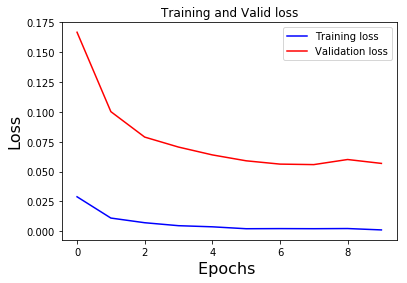

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), validation_loss, 'r', label='Validation loss')
plt.title('Training and Valid loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

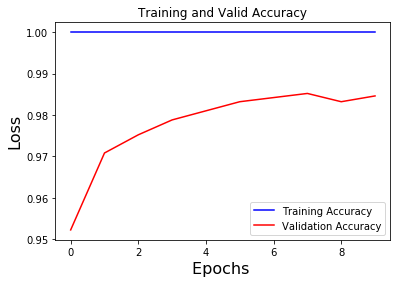

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Valid Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()